In [ ]:
#Manipulação
import pandas as pd
import numpy as np

#Dataprep
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#Visualização
import matplotlib.pyplot as plt
import seaborn as sns

#Clusterização
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [ ]:
#Leitura dos dados
df = pd.read_csv("orders.csv")
df.head()

,order_id,store_id,channel_id,payment_order_id,delivery_order_id,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,...,order_moment_delivering,order_moment_delivered,order_moment_finished,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time
0,68405119,3512,5,68405119,68405119,CANCELED,62.7,0.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68405123,3512,5,68405123,68405123,CANCELED,62.7,0.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68405206,3512,5,68405206,68405206,CANCELED,115.5,0.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68405465,3401,5,68405465,68405465,CANCELED,55.9,0.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,68406064,3401,5,68406064,68406064,CANCELED,37.9,0.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Remoção de Outliers

In [ ]:
#Corte de outliers
df_orders = df[(df['order_amount'] >= 15) &
          (df['order_amount'] <= 200)]

## Ajuste da base por lojas

In [ ]:
#Agrupamento da base final
df_group = df_orders.groupby(['store_id']) \
  .agg({'order_amount':'sum',
        'order_metric_collected_time':'median',
        'order_metric_paused_time':'median',
        'order_metric_production_time':'median',
        'order_metric_walking_time':'median',
        'order_metric_expediton_speed_time':'median',
        'order_metric_transit_time':'median',
        'order_metric_cycle_time':'median',
        'order_id':'count'}) \
  .reset_index() \
  .sort_values('order_id', ascending=False)

df_group=df_group.rename(columns = {'order_amount':'total_order_amount','order_id':'demanda'})

df_group.head()

,store_id,total_order_amount,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time,demanda
3,53,913812.19,0.75,2.70,16.17,2.22,4.92,18.38,42.67,13854
131,676,1222637.55,1.67,2.12,22.75,2.00,4.58,14.07,43.83,10669
149,707,930267.31,2.03,2.48,16.32,4.32,6.80,17.30,42.37,7974
21,149,808869.55,1.82,3.95,21.03,4.60,8.25,16.12,48.30,7248
31,274,768194.55,2.30,2.22,20.22,3.43,6.12,15.68,45.31,6873


## Preenchimento dos dados faltantes

In [ ]:
#Preenchimento de dados faltantes
imputer = SimpleImputer(strategy="median")
imputer.fit(df_group)
float_vars =  imputer.transform(df_group)

df_float64 = pd.DataFrame(float_vars, columns=df_group.columns,
                          index=df_group.index)
df_float64.head()

,store_id,total_order_amount,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time,demanda
3,53.0,913812.19,0.75,2.70,16.17,2.22,4.92,18.38,42.67,13854.0
131,676.0,1222637.55,1.67,2.12,22.75,2.00,4.58,14.07,43.83,10669.0
149,707.0,930267.31,2.03,2.48,16.32,4.32,6.80,17.30,42.37,7974.0
21,149.0,808869.55,1.82,3.95,21.03,4.60,8.25,16.12,48.30,7248.0
31,274.0,768194.55,2.30,2.22,20.22,3.43,6.12,15.68,45.31,6873.0


## Escalonamento dos dados

O escalonamento dos dados (ou normalização/padronização) é um passo crucial para a clusterização, especialmente quando usamos algoritmos que dependem de distâncias, como o K-Means e o DBSCAN. A razão principal para isso é que esses algoritmos avaliam a proximidade entre os pontos com base em cálculos de distância, e dados não escalonados podem distorcer esses cálculos. Aqui estão os motivos principais para fazer o escalonamento:

- Uniformizar a Contribuição de Cada Variável
Em muitos conjuntos de dados, as variáveis podem ter diferentes escalas. Por exemplo, se você tem uma variável idade variando de 0 a 100 e uma variável salário na faixa de milhares ou milhões, a diferença nas escalas fará com que o salário domine as distâncias calculadas.
- Sem escalonamento, o algoritmo de clusterização tende a priorizar variáveis com valores numéricos maiores, mesmo que não sejam as mais relevantes para a clusterização.
- Escalonar os dados (como aplicar uma padronização para média = 0 e desvio padrão = 1, ou normalização para um intervalo fixo, como [0, 1]) coloca todas as variáveis na mesma escala e impede que uma variável ofusque outras.

In [ ]:
#Escalonamento de dados
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_float64)
data_scaled

array([[-1.49709994,  8.71485664, -0.86568178, ..., -0.15970408,
        -0.20111086, 12.17393183],
       [-1.02888681, 11.75706722, -0.52809139, ..., -0.28418118,
        -0.19993026,  9.29688791],
       [-1.00558888,  8.87695453, -0.3959908 , ..., -0.19089556,
        -0.20141619,  6.86246614],
       ...,
       [-0.95748994, -0.28669329, -0.23086506, ..., -0.45602311,
        -0.18472487, -0.33962841],
       [-0.66363547, -0.28645687, -0.23086506, ..., -0.13082309,
         2.89875279, -0.33962841],
       [ 1.66615702, -0.2855959 ,  0.43697681, ..., -0.2789826 ,
        -0.21489138, -0.33962841]])

## Elbow Method (Técnica do cotovelo)

A técnica do cotovelo (ou "elbow method") é uma abordagem visual para encontrar o número ideal de clusters em algoritmos de clusterização, especialmente no K-Means. A ideia principal é analisar como a soma dos erros quadráticos (ou inércia) dentro dos clusters se comporta em relação ao número de clusters,
𝑘
k, para identificar o ponto em que adicionar mais clusters passa a trazer poucos benefícios.

### Como Funciona a Técnica do Cotovelo
 - Escolher uma faixa de valores para
𝑘
k: Em geral, testamos valores de
𝑘
k entre 1 e 10 ou até um pouco mais, dependendo da complexidade e do tamanho do dataset.

- Calcular a inércia para cada
𝑘
k: A inércia mede a “compacidade” dos clusters, ou seja, o quão próximos os pontos estão de seus respectivos centros. Ela é calculada como a soma das distâncias quadráticas dos pontos ao centro do cluster. Quanto menor a inércia, mais compactos são os clusters.

- Plotar
𝑘
k contra a inércia: Em um gráfico, plote o número de clusters
𝑘
k no eixo x e a inércia no eixo y. Conforme o número de clusters aumenta, a inércia diminui, já que os pontos estão mais próximos de seus centros.

- Identificar o “cotovelo” do gráfico: O ponto do cotovelo é aquele em que a taxa de redução da inércia começa a diminuir. Visualmente, ele se parece com um cotovelo no gráfico. Esse ponto indica o número ideal de clusters, pois adicionar mais clusters além desse ponto traz uma diminuição pequena na inércia, ou seja, não melhora significativamente a compactação dos clusters.

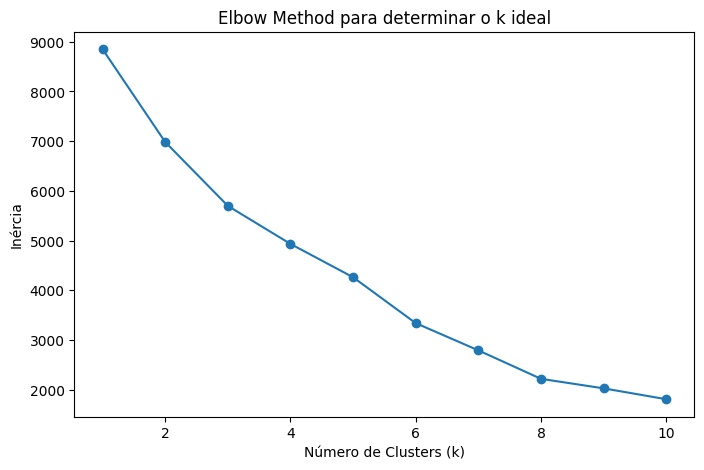

In [ ]:
# Elbow Method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Elbow Method para determinar o k ideal')
plt.show()


## K-Means

O K-Means segue uma abordagem iterativa de particionamento dos dados. O objetivo é minimizar a distância dos pontos de cada cluster ao centro desse cluster (também chamado de centróide).

- Definir o Número de Clusters (K): O usuário escolhe quantos clusters deseja. Esse valor pode ser ajustado com a técnica do cotovelo (elbow method) para encontrar um número apropriado.

- Inicialização dos Centróides: O algoritmo escolhe aleatoriamente
𝐾
K pontos iniciais no espaço dos dados para serem os centróides dos clusters.

- Atribuição dos Pontos aos Clusters: Para cada ponto de dado, o K-Means calcula a distância entre o ponto e cada um dos centróides. O ponto é então atribuído ao cluster cujo centróide estiver mais próximo.

- Recalcular os Centróides: Após a atribuição inicial, o algoritmo recalcula o centróide de cada cluster como a média dos pontos atribuídos a ele.

- Repetir os Passos de Atribuição e Recalcular: Os passos de atribuição e recalculação continuam iterativamente até que:

- Os centróides não mudem significativamente entre uma iteração e outra.
Um número máximo de iterações seja alcançado (um critério de parada para evitar loops infinitos).

- Resultado: Ao final, temos
𝐾
K clusters, onde cada ponto pertence ao cluster com o centróide mais próximo. O algoritmo busca minimizar a soma das distâncias quadráticas dos pontos ao seu centróide.

In [ ]:
# K-Means com clusterização ideal
kmeans = KMeans(n_clusters=6, random_state=42)
df_float64['kmeans_cluster'] = kmeans.fit_predict(data_scaled)

In [ ]:
df_float64['kmeans_cluster'].value_counts()

,count
kmeans_cluster,
0,542
5,297
2,22
4,22
3,1
1,1


## DBSCAN

O DBSCAN (Density-Based Spatial Clustering of Applications with Noise) é um algoritmo de clusterização baseado em densidade. Diferente do K-Means, que agrupa dados em torno de centróides e exige que o número de clusters seja pré-definido, o DBSCAN identifica clusters de qualquer forma e não exige um número específico de clusters. Ele também é capaz de detectar pontos de dados "isolados" ou "ruído" e marcá-los como tal, o que o torna uma boa escolha para dados com outliers.

###Como Funciona o DBSCAN
O DBSCAN forma clusters ao explorar a densidade dos pontos em um espaço de dados. Ele considera três conceitos principais:

- Ponto Central (Core Point): Um ponto é considerado um "ponto central" se houver pelo menos um número mínimo de outros pontos dentro de um certo raio em torno dele. Esse número mínimo é definido pelo parâmetro min_samples e o raio pelo parâmetro
𝜖
ϵ (ou eps).

- Ponto Alcance Direto (Directly Reachable): Um ponto
𝐵
B está em "alcance direto" de um ponto central
𝐴
A se
𝐵
B estiver a uma distância de
𝜖
ϵ ou menos de
𝐴
A.

- Ponto de Borda (Border Point): Um ponto de borda está dentro do alcance de
𝜖
ϵ de um ponto central, mas não possui o número mínimo de pontos ao seu redor para ser considerado um ponto central.

- Ruído (Noise): Pontos que não pertencem a nenhum cluster são considerados ruído.

###Passo a Passo do DBSCAN
- Escolha de um ponto não visitado: O algoritmo começa com um ponto qualquer do conjunto de dados.

- Verificação de Densidade: Se o ponto possui ao menos min_samples pontos dentro da distância
𝜖
ϵ, ele é marcado como ponto central e forma-se um novo cluster em torno dele.

- Expansão do Cluster: Para cada ponto central encontrado, o algoritmo tenta expandir o cluster verificando os pontos que estão ao alcance
𝜖
ϵ. Se esses pontos também forem pontos centrais, eles são adicionados ao cluster e o processo de expansão continua.

- Identificação de Ruído: Pontos que não se conectam a nenhum ponto central (ou estão fora do alcance
𝜖
ϵ de um ponto central) são considerados ruído.

- Repetição: Esse processo se repete até que todos os pontos sejam classificados como parte de um cluster ou como ruído.

### Principais Parâmetros
- eps (epsilon): Define o raio de proximidade ao redor de cada ponto. Quanto maior o valor de eps, mais pontos serão agrupados em torno de um ponto central, formando clusters maiores.
- min_samples: Define o número mínimo de pontos necessários dentro do raio eps para que um ponto seja considerado um ponto central.
- Esses parâmetros são cruciais para o desempenho do DBSCAN. O k-dist plot, que discutimos anteriormente, é uma técnica usada para encontrar um bom valor para
𝜖
ϵ.

In [ ]:
#Define a faixa de busca
min_samples = 11
k = min_samples - 1

##NearestNeighbors
A classe NearestNeighbors do scikit-learn é uma ferramenta para encontrar os vizinhos mais próximos de cada ponto em um conjunto de dados. Ela é essencial para tarefas como busca de similaridade, redução de dimensionalidade e até clusterização (como no ajuste de parâmetros do DBSCAN).

In [ ]:
#aplicar a técnica de NearestNeighbors para encontrar os dados
nbrs = NearestNeighbors(n_neighbors=k).fit(data_scaled)
distances, indices = nbrs.kneighbors(data_scaled)

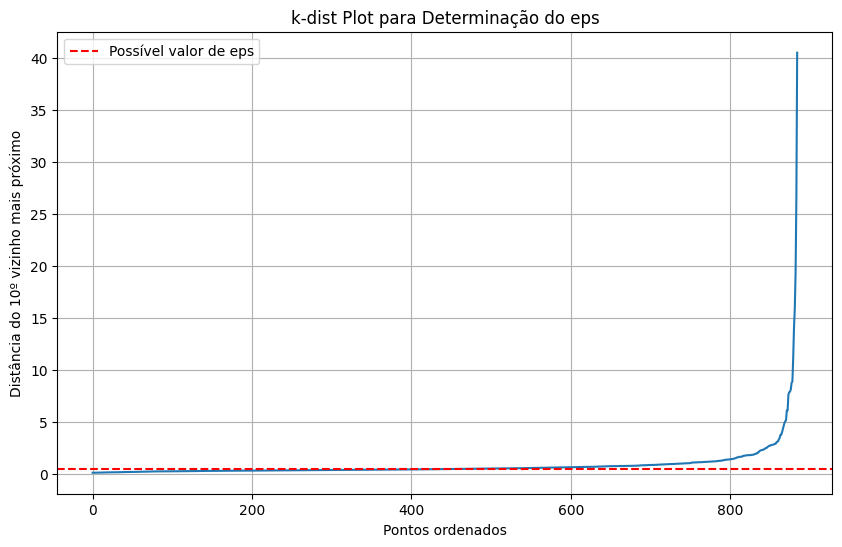

In [ ]:
# obter as distâncias do k-ésimo vizinho para cada ponto e ordenar
k_distances = np.sort(distances[:, k-1])

# plotar o k-dist plot para identificar o valor de eps
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.axhline(y=0.5, color='r', linestyle='--', label='Possível valor de eps')
plt.title("k-dist Plot para Determinação do eps")
plt.xlabel("Pontos ordenados")
plt.ylabel(f"Distância do {k}º vizinho mais próximo")
plt.legend()
plt.grid()
plt.show()

In [ ]:
!pip install kneed

In [ ]:
#Utilizar o kneed para identificar o k ideal
from kneed import KneeLocator
kneedle = KneeLocator(range(len(k_distances)), k_distances, S=1.0, curve="convex", direction="increasing")
eps_value = k_distances[kneedle.knee]
eps_value

2.8454872134609683

In [ ]:
#aplica o DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=11)
df_float64['dbscan_cluster'] = dbscan.fit_predict(data_scaled)

## PCA

A Análise de Componentes Principais (PCA, do inglês Principal Component Analysis) é uma técnica estatística amplamente utilizada para redução de dimensionalidade, simplificação de conjuntos de dados complexos e identificação de padrões. Vou detalhar como o PCA funciona, seus objetivos, passos e aplicações.

### Objetivos do PCA
- Redução de Dimensionalidade: Diminuir o número de variáveis (dimensões) mantendo a maior parte da variabilidade dos dados. Isso é útil em situações em que se lida com dados de alta dimensão, onde muitos recursos podem ser redundantes ou irrelevantes.

- Eliminação de Ruído: Ao focar nas componentes que retêm a maior parte da variância, o PCA pode ajudar a eliminar o ruído nos dados.

- Facilitação da Visualização: Reduzir dados para 2 ou 3 dimensões para que se possam visualizar e interpretar os padrões de forma mais intuitiva.

- Descoberta de Padrões: Ao projetar os dados em um espaço onde as variáveis são não correlacionadas, o PCA pode ajudar a revelar estruturas e padrões que não são facilmente observáveis nos dados originais.

### Como Funciona o PCA
O PCA envolve uma série de etapas:

- Centralização dos Dados: Subtrair a média de cada variável para que os dados tenham média zero.

- Cálculo da Matriz de Covariância: A matriz de covariância mede como duas variáveis variam juntas. Essa matriz é fundamental para entender a relação entre as variáveis no conjunto de dados.

- Cálculo dos Autovalores e Autovetores: Os autovalores representam a quantidade de variância que cada componente principal captura, e os autovetores representam as direções dos componentes principais no espaço de dados. Os autovalores e autovetores são extraídos da matriz de covariância.

- Ordenação dos Autovalores e Autovetores: Os autovalores são ordenados do maior para o menor, e os autovetores correspondentes também são ordenados. Os autovetores com os maiores autovalores formam as componentes principais.

- Projeção dos Dados: Os dados originais são projetados nos novos eixos definidos pelas componentes principais. Isso resulta em um novo conjunto de dados com um número reduzido de dimensões.

In [ ]:
#Shape dos dados
data_scaled.shape

(885, 10)

In [ ]:
# Reduzir para de 10 para 9 dimensões
pca = PCA(n_components=9)
df_pca = pca.fit_transform(data_scaled)
df_pca.shape

(885, 9)

## PCA para Visualização 2D

In [ ]:
# PCA para visualização 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
df_float64['PCA1'] = data_pca[:, 0]
df_float64['PCA2'] = data_pca[:, 1]

## KMEANS Clusters

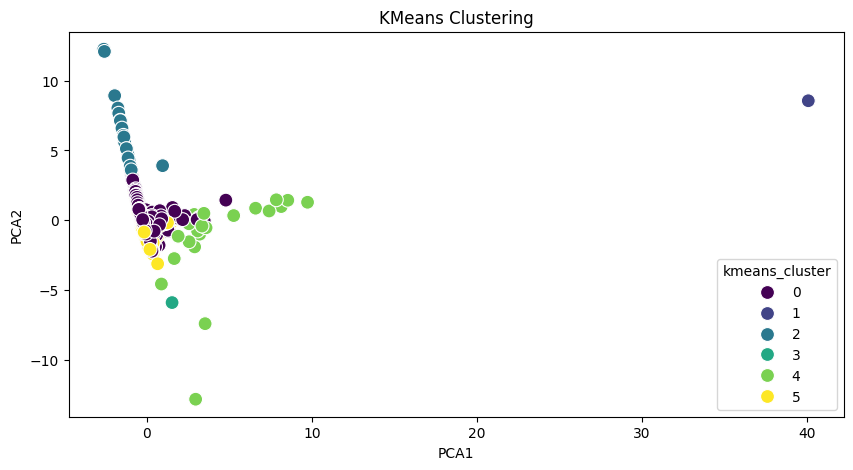

In [ ]:
# Visualize KMeans Clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue='kmeans_cluster', data=df_float64, palette='viridis', s=100)
plt.title('KMeans Clustering')
plt.show()

## DBSCAN Clustering

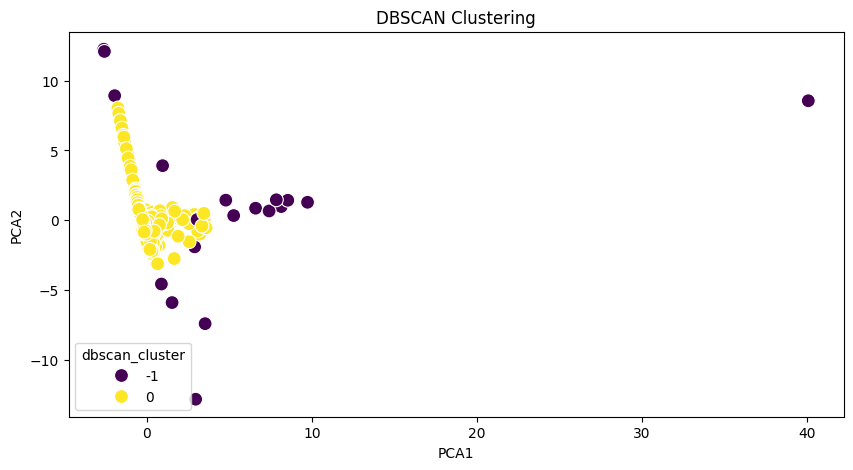

In [ ]:

# Visualize DBSCAN Clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue='dbscan_cluster', data=df_float64, palette='viridis', s=100)
plt.title('DBSCAN Clustering')
plt.show()

In [ ]:
df_float64['dbscan_cluster'].value_counts()

,count
dbscan_cluster,
0,866
-1,19
